# Text classification with LSTM (RNN)

## Import Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
# import plotly.plotly as py
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
import matplotlib as mpl
from matplotlib import pyplot
import os
import jieba # 中文分词组件
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\idgca\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import data

In [11]:
def read_data(rootdir, target_name, target_index):
    
    for root, subdirs, files in os.walk(rootdir):
        for file in files:
            path = root+'/'+file
            with open(path, encoding="utf8") as f:
                input_file = f.read()
                data.append(input_file)
                target_names.append(target_name)
                target.append(target_index)

data = []
target_names = []
target = []
read_data("../data/classification_data_v3/中性", "中性", 0)
read_data("../data/classification_data_v3/买入", "买入", 1)
read_data("../data/classification_data_v3/卖出", "卖出", 2)

In [14]:
# combine data to single dataframe
df_raw = pd.DataFrame()
df_raw['data'] = data
df_raw['target_names'] = target_names
df_raw['target'] = target
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23769 entries, 0 to 23768
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   data          23769 non-null  object
 1   target_names  23769 non-null  object
 2   target        23769 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 557.2+ KB


In [15]:
df_raw.target_names.value_counts()
df_raw.target.value_counts()

买入    17123
中性     6634
卖出       12
Name: target_names, dtype: int64

1    17123
0     6634
2       12
Name: target, dtype: int64

In [16]:
df_raw.head()

,data,target_names,target
0,\n \n \n \n[Table_main] 公司研究类模板 \n 顺丰控股(0023...,中性,0
1,公\n司\n研\n究 DONGXING SECURITIES \n \n华域汽车（6007...,中性,0
2,\n \n公 汽车和汽车零部件 \n \n司 2020 年 02 月 24日 \n报 长城...,中性,0
3,\n \n仅供机构投资者使用 \n证券研究报告|公司点评报告 \n [Table_2D0a...,中性,0
4,\n \n \n证券研究报告 \n公司研究/公告点评 \n2020年02月24日 基础化工...,中性,0


## Data exploration

In [18]:
df_raw['target_names'].value_counts().\
sort_values(ascending=False).iplot(kind='bar', 
                                   yTitle='Number of Documents',
                                   title='Number of Documents in each category')

In [19]:
df = df_raw

In [20]:
# audit dataframe (check for nulls)
def table_info(data):
    tab_info=pd.DataFrame(data.dtypes).T.rename(index={0:'column type'})
    tab_info=tab_info.append(pd.DataFrame(data.isnull().sum()).T.rename(index={0:'null values (nb)'}))
    tab_info=tab_info.append(pd.DataFrame(data.isnull().sum()/data.shape[0]*100).T.rename(index={0:'null values (%)'}))
    return tab_info

table_info(df)

,data,target_names,target
column type,object,object,int64
null values (nb),0,0,0
null values (%),0,0,0


## Data preprocessing

In [90]:
# print one sample
def print_data(index):
    example = df[df.index == index][['data', 'target']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Category:', example[1])

print_data(100)

证 券 研 公司 究 深度 公研 司究 深 度 佳讯 研飞究 鸿 佳讯 飞鸿 西 西部 部证 证券 券 报 2020 年 08 月 17 日 2020 年 08 月 17 日 告 铁路 指挥 调度 龙头 乘 5G 春风 腾飞 在 即 佳讯 飞鸿 300213 SZ 首次 覆盖 Tabl e _ Title 核心 结论 公司 评级 买入 ● 股票代码 300213 Tab le _ Summ 铁 ary 路 智慧 指挥 调度 领域 龙头 业绩 增长 稳健 公司 深耕 铁路 智慧 指挥 调度 领 前次 评级 域 二十余载 主营 指挥 调度 类 智能 应用 类 行业 物 联网 应用 类及 维护 服务 评级 变动 首次 类 四大 业务 公司 产品 主要 应用 于 交通 国防 政府 及 能源 等 领域 2019 年 当前 价格 8 71 实现 营收 13 39 亿 同比 + 10 1 净利润 1 53 亿 同比 + 17 7 分 业务 看 指挥 调度 类 智能 应用 行业 物 联网 应用 类 分别 占 比 59 6 21 8 13 2 ； 近 一年 股价 走势 分行业 看 交通 国防 及 政府 领域 分别 占 比 62 5 15 5 15 7 佳讯 飞鸿 通信 设备 创业板 指 68 5G 轨交 应用 在 即 市场 空间 弹性 大 2020 年 上半年 全国 铁路 固定资产 投资 55 3258 亿 超 去年同期 38 亿 多 地区 铁路局 确认 或 明确 将 调增 投资 额度 全 42 29 年 有望 超 8200 亿 行业 景气 度高 5G 轨交 应用 在 即 根据 我们 测算 当 16 前 GSM R 市场 规模 约 22 1 ~ 29 5 亿 随着 在 运营 铁路 通信 设备 进入 更换 期 3 10 及 新建 铁路 里程 持续增长 未来 5G R 市场 空间 有望 扩展 成 当前 3 4 ~ 9 5 2019 08 2019 12 2020 04 倍 公司 在 铁路 指挥 调度 市场份额 超 50 将 充分 受益 5G R 应用 分析师 国防 信息化 潜力 广阔 或成 新 利润 增长点 国防 专网 调度 具有 严格 准入 机 制 公司 早 在 1999 年 就 开始 涉及 国防 专网 调度 业务 具有 较强 客户 粘性 在 邢开 允 S0800519070001 该

In [22]:
df_backup = df

In [168]:
# sampling只是为了找小一点的样本，训练速度快一些，来找问题。
# LSTM 0.759 的结果是使用全部数据2.4万训练得来的
df_type1 = df_backup.loc[((df_backup['target']==1))].sample(n = 2000)
df_type0 = df_backup.loc[((df_backup['target']==0))].sample(n = 2000)
df = pd.concat([df_type1, df_type0])
df = df.reset_index(drop=True)
df.target_names.value_counts()

中性    2000
买入    2000
Name: target_names, dtype: int64

In [170]:
df_sample = df
df_sample

,data,target_names,target
0,\n \n仅供机构投资者使用 \n证券研究报告 |公司点评报告 \n [Table_2 ...,买入,1
1,\n \n公司报告 | 年报点评报告 \n \n海尔智家（600690） 证券研究报告 ...,买入,1
2,\n5[Table_Message2]0 20-04-21 \n \n公司点评报告 \n公...,买入,1
3,\n \n证券研究报告 \n公司研究/年报点评 \n2020年04月16日 建筑/建筑装饰...,买入,1
4,\n \n \n[T[Tabablel_e_MTaitinleI]n fo] [T abl...,买入,1
...,...,...,...
3995,\n \nTable_BaseI nfo \nTable_Tti le \n2020 年...,中性,0
3996,[Table_Industry] \n \n证券研究报告/公司点评 2020 年 07 ...,中性,0
3997,\n\n汽车 \n\n报告原因：半年报点评 \n2020 年 8 月 27 日 \n\n ...,中性,0
3998,\n舍得酒业 600702.SH \n \n舍得升级沱牌复兴，机制改革效率提升 \n ...,中性,0


In [171]:
df.to_csv(r'../data/data_sample.csv',header=True,index=None)


In [172]:
df = df_sample
file_name = '../data/dict.txt'
# 自定义词汇
jieba.load_userdict(file_name) 
# 标点
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;.。%-]')
# 停止词（未完）
STOPWORDS = {"的","和","\n"," "} 
def clean_text(text):
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # 移除标点
    text = re.compile('[，（）%％《》、:：]').sub(' ', text) # 移除中文标点
#     text = ''.join(re.findall(r'[\u4e00-\u9fa5]', text)) # 只留中文词
    wordlist = jieba.lcut(text, cut_all=False) # 分词
    text = ' '.join(word for word in wordlist if word not in STOPWORDS) # 移除停止词并合并
    text = text.replace('\n','') # 移除特殊字符
    text = text.replace('\0', '')
    text = text.replace('\t', ' ')
    return text

df['data'] = df['data'].apply(clean_text)
# df['data'] = df['data'].str.replace('\d+', '') # 移除所有数字

In [173]:
df = df[['target', 'data']]
df.head()
table_info(df)
print("Empty data count: ", len(df.loc[df['data']==""])) # 空字符串
df = df[df['data']!=""]
print("Empty data removed. ", len(df.loc[df['data']==""]))

,target,data
0,1,仅供机构投资者使用 证券研究报告 |公司点评报告 [Table_2 D0a2t0 e...
1,1,公司报告 | 年报点评报告 海尔智家（600690） 证券研究报告 2020 年 ...
2,1,5[Table_Message2]0 20-04-21 公司点评报告 公 买入/维持 司...
3,1,证券研究报告 公司研究/年报点评 2020年04月16日 建筑/建筑装饰Ⅱ 投资评级：...
4,1,[T[Tabablel_e_MTaitinleI]n fo] [T able_Inve...


,target,data
column type,int64,object
null values (nb),0,0
null values (%),0,0


Empty data count:  17
Empty data removed.  0


## Train/test split

In [174]:
train_index = np.random.rand(len(df)) < 0.8
test_index = ~train_index


df_train_val = df[train_index].reset_index(drop=True)
df_test = df[test_index].reset_index(drop=True) # get 20% as testing data

In [175]:
train_index = np.random.rand(len(df_train_val)) < 0.8
val_index = ~train_index

df_train = df_train_val[train_index].reset_index(drop=True) # get 64% as training data
df_val = df_train_val[val_index].reset_index(drop=True) # get 16% as validation data 

In [176]:
len(df_train)
len(df_test)
len(df_val)

2540

775

668

### save train test val split for bert

In [178]:
df_train.to_csv(r'../data/train.csv',
          header=False,
          index=None,  
          encoding='utf_8_sig', 
          sep='\t')
df_test.to_csv(r'../data/test.csv',
          header=False,
          index=None,  
          encoding='utf_8_sig', 
          sep='\t')
df_val.to_csv(r'../data/val.csv',
          header=False,
          index=None,  
          encoding='utf_8_sig', 
          sep='\t')

In [179]:
df_test2 = pd.read_csv(r'../data/test.csv',header=None,sep='\t')
df_test2.head()
table_info(df_test2)
len(df_test2)

,0,1
0,1,仅供机构投资者使用 证券研究报告 |公司点评报告 [Table_2 D0a2t0 e...
1,1,[Table_Message]2 020-08-14 公司研究报告 公 买入/维持 司研...
2,1,2020 年 3 月 3 日 长春高新（000661.SZ） 医药...
3,1,[新Tab易le_盛Titl(e]3 00502) 公司研究/点评报告 业绩创新高，5G+...
4,1,Tabel _BaseI nof Table_Tit el 2020 年 07 月...


,0,1
column type,int64,object
null values (nb),0,0
null values (%),0,0


775

In [180]:
def audit_null(df): 
    return df[df.isnull().any(axis=1)]

audit_null(df_test2)

,0,1


## jieba library functions

In [85]:
wordlist = jieba.lcut(temp)
text = nltk.Text(wordlist)
print(text)

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\idgca\AppData\Local\Temp\jieba.cache
Loading model cost 0.718 seconds.
Prefix dict has been built successfully.


<Text: 公司 报告 年报 点评 报告 中科 创达 证券...>


In [88]:
# 搜索上下文
text.concordance(word='报告',width=20,lines=10)

Displaying 10 of 33 matches:
公司 报告 年报 点评 报告
报告 年报 点评 报告 中科 创达 证券
创达 证券 研究 报告 年月日 投资 评
贝格 数据 相关 报告 中科 创达 季报
免责 申明 公司 报告 年报 点评 报告
报告 年报 点评 报告 财务 预测 摘要
免责 申明 公司 报告 年报 点评 报告
报告 年报 点评 报告 分析师 声明 本
分析师 声明 本 报告 署名 分析师 在
 胜任 能力 本 报告 所 表述 的 所


In [92]:
# 搜索共同上下文
text.common_contexts(['报告','公司'])
# 统计词频
text.count(word='报告')

No common contexts were found


33

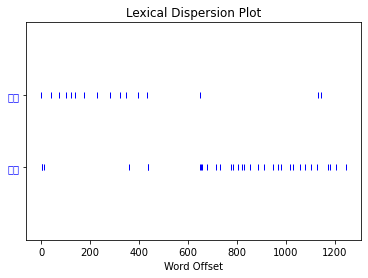

In [94]:
# 离散图
words=['公司','报告']
text.dispersion_plot(words)

In [97]:
# 计算词汇相似度
text.similar(word='报告',num=10)

from nltk.text import ContextIndex
contentindex = ContextIndex(wordlist)
similarity_scores = contentindex.word_similarity_dict(word='报告')
for key,value in similarity_scores.items():
    if value>0.02:
        print(key,value)

发布
报告 1.0
发布 0.08333333333333333


## Tokenize documents

In [183]:
# 词汇量最大值
MAX_NO_WORDS = 10000
EMBEDDING_DIM = 100
tokenizer = Tokenizer( filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, num_words=MAX_NO_WORDS) #num_words=MAX_NB_WORDS,
tokenizer.fit_on_texts(df['data'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 595390 unique tokens.


## Save processed data to csv

In [184]:
df.to_csv(r'../data/cleaned.csv',header=True,index=None)

In [185]:
def count_text(text):
    return len(text.split(' '))
    
df['word_count'] = df.data.apply(count_text) # 新加一栏词汇量
df['word_count']

0        829
1       1290
2        611
3       1353
4       1689
        ... 
3995    1486
3996     912
3997     962
3998    1307
3999    1449
Name: word_count, Length: 3983, dtype: int64

In [186]:
np.mean(df['word_count']) # each document has average 1600 words after processing 

1599.4903339191565

## Get train test datasets

In [187]:
X = tokenizer.texts_to_sequences(df['data'].values)


In [188]:
# Max number of words in each document.
MAX_SEQUENCE_LENGTH = 500
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH) 
print('Shape of data tensor:', X.shape)

Shape of data tensor: (3983, 500)


In [189]:
Y = pd.get_dummies(df['target']).values
Y_single = df['target']
print('Shape of label tensor:', Y.shape)
print('Shape of label tensor:', Y_single.shape)

Shape of label tensor: (3983, 2)
Shape of label tensor: (3983,)



## Train test split

In [190]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(3186, 500) (3186, 2)
(797, 500) (797, 2)


## LSTM

In [191]:
def create_model(
                units=100,
                dropout=0.1,
                recurrent_dropout=0.1,
                loss='binary_crossentropy',
                optimizer='adam',
                dense_units=2,
                activation='sigmoid'
                ):
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.2))
    # units: Positive integer, dimensionality of the output space.
    # dropout: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs
    # recurrent_dropout: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state
    model.add(LSTM(units, dropout=dropout, recurrent_dropout=recurrent_dropout))
    # units: Positive integer, dimensionality of the output space
    model.add(Dense(dense_units, activation=activation))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

epochs = 5
batch_size = 64

# # wrap into a scikit learn model for pipelining the process
# clf = KerasRegressor(build_fn=create_model, verbose=0, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

# # for piplining the process
# pipeline = Pipeline([
#     ('clf',clf)
# ])

# history = pipeline.fit(X_train, Y_train)

history = create_model().fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

C:\Users\idgca\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 2867 samples, validate on 319 samples
Epoch 1/5
2867/2867 [==============================] - 30s 10ms/step - loss: 0.6581 - accuracy: 0.6217 - val_loss: 0.6224 - val_accuracy: 0.6411
Epoch 2/5
2867/2867 [==============================] - 29s 10ms/step - loss: 0.6058 - accuracy: 0.6697 - val_loss: 0.6222 - val_accuracy: 0.6552
Epoch 3/5
2867/2867 [==============================] - 29s 10ms/step - loss: 0.5929 - accuracy: 0.6761 - val_loss: 0.6179 - val_accuracy: 0.6536
Epoch 4/5
2867/2867 [==============================] - 29s 10ms/step - loss: 0.5828 - accuracy: 0.6849 - val_loss: 0.6243 - val_accuracy: 0.6724
Epoch 5/5
2867/2867 [==============================] - 29s 10ms/step - loss: 0.5848 - accuracy: 0.6842 - val_loss: 0.6251 - val_accuracy: 0.6661


## Train Results:
0. full data (24k), all preprocessing steps, 3 epochs
    1. val_accuracy: **0.7629**
    2. test_accuracy: **0.759**
    3. naive_base: **0.817**
    
1. sample data (2k) includes numbers, added a few stop words and common phrases, 3 epoch
    1. sample data only includes 2 cases
    2. val_accuracy: 0.7688
    3. test_accuracy: 0.565
    4. naive_base: 0.575
    
2. sample data (2k) removes numbers, 3 epoch
    1. val_accuracy: 0.7437
    3. test_accuracy: 0.499
    4. naive_base: 0.65
3. sample data (2k) no processing, 3 epoch
    1. val_accuracy: 0.7500
    3. test_accuracy: 0.526
    4. naive_base: 0.585

In [192]:
# predicted = pipeline.predict(X_test)
# # print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(predicted[0],predicted[1]))

predicted = create_model().evaluate(X_test, Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(predicted[0],predicted[1]))


797/797 [==============================] - 1s 2ms/step
Test set
  Loss: 0.693
  Accuracy: 0.511


### plot training loss

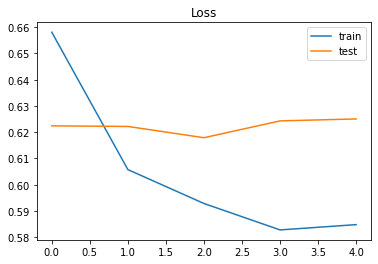

In [193]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

### plot training accuracy (slightly overfit after 4 epoch)

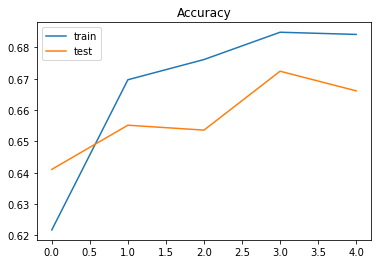

In [194]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

## Naive base

In [195]:
# pipeline
text_clf_nb = Pipeline([
                        ('vect', CountVectorizer(lowercase=False)), 
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB(alpha=0.01)), 
                    ])

In [196]:
X_train, X_test, Y_single_train, Y_single_test = train_test_split(df['data'],df['target'], test_size = 0.20, random_state = 42)
print(X_train.shape,Y_single_train.shape)
print(X_test.shape,Y_single_test.shape)

(3186,) (3186,)
(797,) (797,)


In [197]:
text_clf_nb = text_clf_nb.fit(X_train, Y_single_train)

In [198]:
predicted = text_clf_nb.predict(X_test)
np.mean(predicted == Y_single_test)

0.7151819322459222